In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import torch
import numpy as np
import torch.nn as nn


import pyroml as p
from pyroml.template.iris import IrisNet, IrisDataset, load_dataset

In [31]:
SEED = 42
p.seed_everything(SEED)

In [32]:
ds = load_dataset()
ds = ds.shuffle(seed=SEED)
tr_ds, ev_ds, te_ds = np.split(ds, [int(0.6 * len(ds)), int(0.7 * len(ds))])

tr_ds = IrisDataset(tr_ds)
ev_ds = IrisDataset(ev_ds)
te_ds = IrisDataset(te_ds)

In [33]:
class ScheduledIrisNet(IrisNet):
    def configure_optimizers(self, loop: "p.Loop"):
        tr = self.trainer
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=tr.lr)
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=tr.lr,
            total_steps=loop.total_steps,
            steps_per_epoch=loop.steps_per_epochs,
            epochs=tr.max_epochs,
            anneal_strategy="cos",
            cycle_momentum=False,
            div_factor=1e2,
            final_div_factor=0.05,
        )

    def forward(self, x):
        return super().forward(x)

In [34]:
model = ScheduledIrisNet()
model

ScheduledIrisNet(
  (module): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)

In [35]:
import logging
trainer = p.Trainer(
    compile=True,
    loss=nn.CrossEntropyLoss(),
    max_epochs=12,
    batch_size=16,
    lr=0.005,
    evaluate=True,
    evaluate_every=12,
    wandb=False,
    dtype=torch.bfloat16,
    log_level=logging.INFO,
)

In [36]:
tr_tracker = trainer.fit(model, tr_ds, ev_ds)
tr_tracker.records

TypeError: super(type, obj): obj must be an instance or subtype of type

In [55]:
from torchmetrics import MetricTracker, MetricCollection
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall

In [59]:
t = MetricTracker(
    metric=MetricCollection({"acc": BinaryAccuracy(), "pre": BinaryPrecision(), "rec": BinaryRecall()}),
)
t.increment()
t(torch.tensor([0, 0]), torch.tensor([0, 1])), t.compute(), t.increment(), t(
    torch.tensor([0, 1]), torch.tensor([1, 1])
), t.compute(), t.compute_all()

({'acc': tensor(0.5000), 'pre': tensor(0.), 'rec': tensor(0.)},
 {'acc': tensor(0.5000), 'pre': tensor(0.), 'rec': tensor(0.)},
 None,
 {'acc': tensor(0.5000), 'pre': tensor(1.), 'rec': tensor(0.5000)},
 {'acc': tensor(0.5000), 'pre': tensor(1.), 'rec': tensor(0.5000)},
 {'acc': tensor([0.5000, 0.5000]),
  'pre': tensor([0., 1.]),
  'rec': tensor([0.0000, 0.5000])})

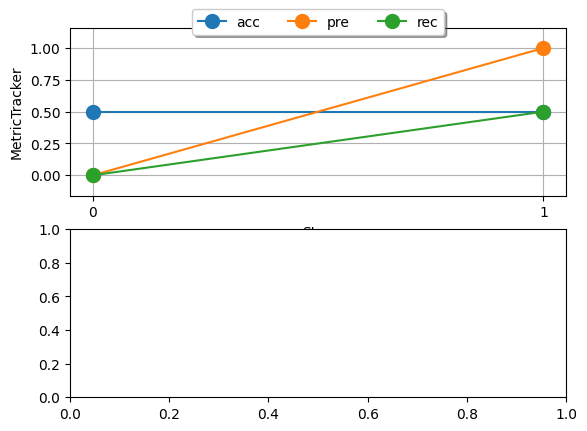

In [64]:
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(2, 1)
t.plot(ax=axs[0])
plt.show()

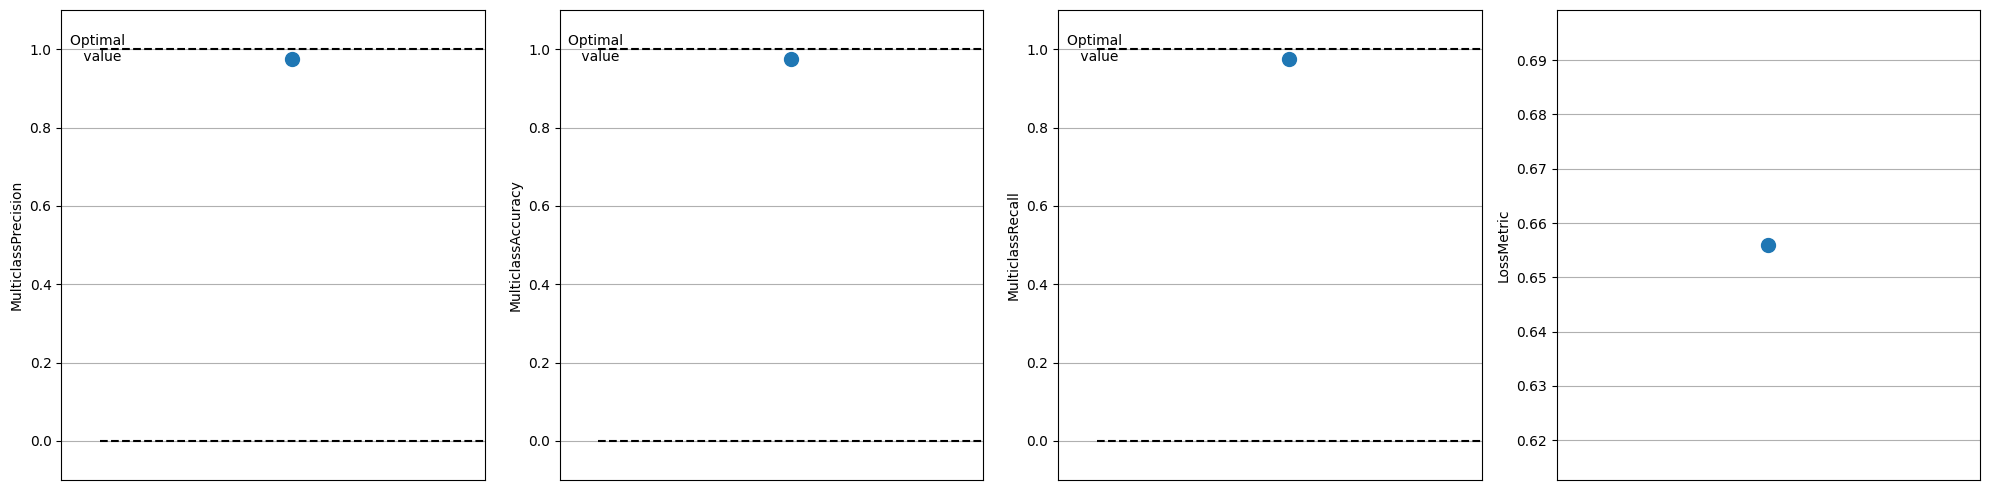

In [23]:
tr_tracker.plot()

In [11]:
te_metrics = trainer.test(model, te_ds)
te_metrics

,stage,epoch,step,pre,acc,rec,loss,epoch_pre,epoch_acc,epoch_rec,epoch_loss
0,test,0,0,1.0,1.0,1.0,0.791728,NaN,NaN,NaN,NaN
1,test,0,1,1.0,1.0,1.0,0.780672,NaN,NaN,NaN,NaN
2,test,0,2,1.0,1.0,1.0,0.768307,NaN,NaN,NaN,NaN
3,test,0,3,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.780236


In [147]:
from torchmetrics.aggregation import MeanMetric
from torchmetrics import Metric, MetricTracker as _MetricTracker, MetricCollection

class LossMetric(Metric):
    def __init__(self):
        super().__init__()
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def update(self, output):
        pred, target = output["pred"], output["target"]
        loss = self.loss_fn(pred, target)
        print('REAL LOSS', loss)
        super().update(loss)

    def compute(self):
        return super().compute()


def output_update(self, output):
    print(output)
    pred, target = output["pred"], output["target"]
    self.update(pred, target)

def convert_to_output_metric(metric: Metric):
    funcType = type(metric.__class__.update)
    print(funcType, metric.__class__.update)
    metric.update = funcType(output_update, metric, Metric)

class MetricTracker(_MetricTracker):
    def __init__(self):
        collection = dict(
            acc=BinaryAccuracy(),
            pre=BinaryPrecision(),
            rec=BinaryRecall(),
        )

        loss = None
        if "loss" in collection:
            loss = collection.pop("loss")
        else:
            loss = LossMetric()

        for metric in collection.values():
            convert_to_output_metric(metric)

        collection = MetricCollection(collection)
        super().__init__(collection)
        self.loss = loss

In [148]:
def output():
    x = torch.rand(2, 3)
    y = torch.nn.functional.one_hot(torch.arange(0, 3) % 3)[:2].float()
    preds = torch.softmax(x, dim=1)
    return { 
        "pred": x, 
        "target": y, 
        "metrics_pred": preds, 
        "metrics_target": y 
    }

t = MetricTracker()
(
    t.increment(),
    t(output()),
    t(output()),
    t(output()),
    t.compute_all(),
    t.increment(),
    t(output()),
    t(output()),
    t.compute(),
    t.compute_all(),
)

<class 'function'> <function BinaryStatScores.update at 0x7075c7071e10>


TypeError: function() argument 'code' must be code, not function